In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
import json
import pydantic

In [2]:
# Load .env file
load_dotenv()
# Read the API key
api_key = os.getenv("GEMINI_API_KEY")

In [3]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=api_key,
    thinking_budget=0
)

messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]

response = model.invoke(messages)
print(response)

content="J'adore la programmation." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'} id='lc_run--019afea0-b9be-7761-b6da-6294da667f66-0' usage_metadata={'input_tokens': 21, 'output_tokens': 7, 'total_tokens': 28, 'input_token_details': {'cache_read': 0}}


In [4]:
with open("problem_statement/POC_sim_D.json", "r") as f:
    data = json.load(f)



In [5]:
data['topicWizardData'].keys()

dict_keys(['lessonInformation', 'assessmentCriterion', 'selectedAssessmentCriterion', 'scenarioOptions', 'selectedScenarioOption', 'simulationName', 'workplaceScenario', 'simulationFlow', 'industryAlignedActivities', 'selectedIndustryAlignedActivities'])

In [6]:
data['topicWizardData']['selectedIndustryAlignedActivities']

[{'name': 'Delivering a Strategic Executive Summary for Leadership',
  'description': 'Learners will assume the role of a business consultant presenting to FreshTaste’s executive team. They will analyze the competitor’s $1 menu strategy, evaluate market and consumer trends, and review FreshTaste’s internal SWOT. Using this analysis, learners will compare four strategic response options and recommend a clear, realistic plan to defend or grow market share. The deliverable is a concise executive summary that synthesizes findings and justifies the chosen strategy for decision-makers. *(KLO 1, KLO 2, KLO 3)*',
  'industryAlignment': 'Executive summaries distill complex analyses into actionable insights for leaders—a core skill in consulting and management. The task requires structured comparison of strategic options, direct evaluation of competitor moves, and the integration of market and internal data—all aligning with how real-world consultants advise brands facing disruptive competition.

In [9]:
simulation_json={}

scenarioOptions = data["topicWizardData"]["scenarioOptions"]
currentScenarioOption = data["topicWizardData"]["selectedScenarioOption"]

list_of_keys = ['lessonInformation', 
                'assessmentCriterion', 
                'selectedAssessmentCriterion',
                'simulationName', 
                'workplaceScenario',
                'industryAlignedActivities', 
                'selectedIndustryAlignedActivities']

for k,v in data["topicWizardData"].items():
    if k in list_of_keys:
        simulation_json[k]=v


In [10]:
newScenarioOption = scenarioOptions[10]
print(f'newScenarioOption: {newScenarioOption}')

newScenarioOption: FlexFit Gym memberships decline after rival BodyWorks introduces steeply discounted annual packages. Learners must recommend whether FlexFit should compete on price, expand digital offerings, or reinforce its premium brand.


## LangGraph

In [11]:

prompt = f'''
You are an expert simulation designer. Your task is to adapt an existing simulation (given as json) to a new scenario while preserving its structure and links.

Here is the current simulation scenario:
OLD SCENARIO: {currentScenarioOption}

Simulation JSON (do not modify the structure or fields):
SIMULATION: {simulation_json}

Your objective:
- Re-contextualize all narrative, descriptions, and scenario-dependent content so that it aligns with the NEW SCENARIO:
NEW SCENARIO: {newScenarioOption}

Constraints:
1. Do not modify the JSON structure, keys, or data types.
2. Locked fields (everything not scenario-dependent) must remain identical.
3. Only adapt scenario-relevant content such as names, roles, narrative, instructions, examples, and context.
4. Ensure global coherence: the adapted simulation should read naturally, reflect the new scenario consistently, and contain no residual references to the old scenario.
5. Preserve formatting, arrays, objects, and any schema constraints.

Deliverable:
- Output ONLY the valid JSON object. Do not include any markdown formatting, code blocks, explanations, or additional text.
- Do not wrap the JSON in ```json or ``` markers.
- Return only the raw JSON that can be directly parsed.
'''

In [12]:
from jsonschema import validate, ValidationError
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from typing import List
from genson import SchemaBuilder

builder = SchemaBuilder()
builder.add_object(simulation_json)
schema = builder.to_schema()

# Graph state
class State(TypedDict):
    val_schema: dict
    generated_schema: str
    evaluator_message: str

    num_retries: int
    history_generator: List[str]
    history_evaluator: List[str]
    message_history: List[dict]
    

def re_contexualize_simulation_agent(state:State):
    response = model.invoke(state['message_history'])
    return {
        'message_history': state['message_history'] + [{"role": "assistant", "content": response.content}],
        'generated_schema': response.content,
        'history_generator': state['history_generator'] + [response.content]
    }
    

def validate_json(state: State):
    # Validate using the generated_schema from state
    try:
        # Clean the generated schema by removing markdown code blocks
        generated_text = state['generated_schema'].strip()
        
        # Remove markdown code blocks if present
        if generated_text.startswith('```'):
            first_newline = generated_text.find('\n')
            last_backticks = generated_text.rfind('```')
            if first_newline != -1 and last_backticks != -1:
                generated_text = generated_text[first_newline+1:last_backticks].strip()
        
        # Parse the generated JSON string
        generated_json = json.loads(generated_text)
        validate(instance=generated_json, schema=state['val_schema'])
        print("JSON Schema Validation OK")
        
        # Return updates
        return {
            'evaluator_message': 'PASS',
            'history_evaluator': state['history_evaluator'] + ['PASS']
        }
        
    except ValidationError as e:
        print("JSON Schema Validation FAILED:", e.message)
        return {
            'num_retries': state['num_retries'] + 1,
            'evaluator_message': f"JSON Schema Validation FAILED: {e.message}",
            'history_evaluator': state['history_evaluator'] + [e.message]
        }
        
    except json.JSONDecodeError as e:
        print("JSON Parse Error:", str(e))
        return {
            'num_retries': state['num_retries'] + 1,
            'evaluator_message': f"JSON Parse Error: {str(e)}",
            'history_evaluator': state['history_evaluator'] + [str(e)]
        }
        
        

def json_format_correction_agent(state: State):
    retry_prompt = f'''
The previous output did not satisfy the required JSON Schema.  
A validation failure occurred with the following message:

{state['evaluator_message']}

You must correct all issues identified by the validator and produce a fully compliant JSON object.  
Carefully review the schema constraints, adjust any incorrect fields or structural inconsistencies, and ensure that:

1. Every key strictly adheres to the expected schema.
2. All value types match the schema requirements.
3. No additional or missing fields exist.
4. Arrays and nested objects follow the exact structure defined by the schema.
5. The JSON remains syntactically valid and properly formatted.

After making the necessary corrections, re-generate the complete JSON output that fully conforms to the schema.  
Provide only the corrected JSON in your response.
'''
    
    response = model.invoke(state['message_history'] + [{"role": "user", "content": retry_prompt}])
    
    # Return the updates
    return {
        'message_history': state['message_history'] + [
            {"role": "user", "content": retry_prompt},
            {"role": "assistant", "content": response.content}
        ],
        'generated_schema': response.content,
        'history_generator': state['history_generator'] + [response.content]
    }


def route_after_validation(state: State) -> str:
    """Router function to decide next step based on validation result"""
    if state['evaluator_message'] == 'PASS':
        return 'Pass'
    elif state['num_retries'] >= 3:
        return 'Retry Limit Exceeded'
    else:
        return 'Fail'

In [13]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("re_contexualize_simulation_agent", re_contexualize_simulation_agent)
workflow.add_node("json_format_correction_agent", json_format_correction_agent)
workflow.add_node("validate_json", validate_json)

# Add edges to connect nodes
workflow.add_edge(START, "re_contexualize_simulation_agent")
workflow.add_edge("re_contexualize_simulation_agent", "validate_json")
workflow.add_conditional_edges(
    "validate_json", 
    route_after_validation, 
    {
        "Fail": "json_format_correction_agent", 
        "Pass": END, 
        "Retry Limit Exceeded": END
    }
)
workflow.add_edge("json_format_correction_agent", "validate_json")

# Compile
chain = workflow.compile()

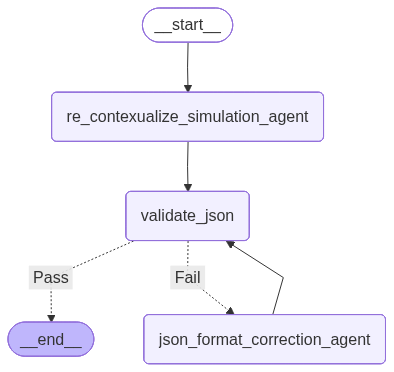

In [14]:
from IPython.display import Image, display
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [15]:
state={}
state['val_schema'] = schema['properties']
state['generated_schema'] = ''
state['evaluator_message'] = ''
state['num_retries'] = 0
state['history_generator'] = []
state['history_evaluator'] = []
state['message_history'] = [{"role": "user", "content": prompt}]

state = chain.invoke(state)

JSON Schema Validation OK


In [16]:
json.loads(state['generated_schema'])

{'lessonInformation': {'level': 'Practice',
  'lesson': "Acting as a consultant, students will develop a short executive summary recommending how a premium gym brand should respond to its competitor's steeply discounted annual packages. They’ll analyze the competitor’s move, market impact, FlexFit’s strengths, and four strategic options. Their goal is to propose a clear, realistic, and sustainable plan to protect or grow market share via an executive summary."},
 'assessmentCriterion': [{'keyLearningOutcome': "Learners will be able to analyze the competitor's discounted membership strategy by examining market trends and consumer behavior to assess its potential impact on FlexFit's performance.",
   'criterion': ["Explains the competitor's discounted membership strategy, highlighting its value proposition and target audience.",
    'Identifies at least two market trends or consumer behaviors relevant to the competitor’s strategy.',
    'Evaluates the likely effects of the discounted pac

# Generate the simulation

In [18]:
simulation_context = state['generated_schema']

In [19]:
print(f'newScenarioOption: {newScenarioOption}')

newScenarioOption: FlexFit Gym memberships decline after rival BodyWorks introduces steeply discounted annual packages. Learners must recommend whether FlexFit should compete on price, expand digital offerings, or reinforce its premium brand.


In [20]:
data['topicWizardData']['simulationFlow']

[{'name': 'Introduction',
  'children': [{'name': 'Manager Video Call',
    'flowProperties': {'purpose': 'Learners receive a video call from their reporting manager, Mark Caldwell, Chief Strategy Officer. This sets the stage for the project scope and establishes the preferred channel for project-related communications moving forward.'},
    'data': {'video': {'url': 'https://vimeo.com/1010185451',
      'selectedAvatar': {'avatarUrl': 'https://cartedo.s3.us-east-2.amazonaws.com/web/7b5d56a3a81925faa1d1.jpg',
       'avatarName': 'Mark Caldwell'}}}},
   {'name': 'Information Email',
    'flowProperties': {'purpose': 'Learners receive an email from their reporting manager, Mark Caldwell, Chief Strategy Officer, providing project details and expectations. This email serves as a formal introduction to the project and outlines the key deliverables and timelines.',
     'hidden': True},
    'data': {'email': {'body': '<p>Dear {{{recipientName}}},</p>\n<p>Welcome to the team. I am glad to ha